In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import os, sys, warnings, pytz
from datetime import datetime
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import time
from sklearn.metrics import mean_squared_error, r2_score, f1_score
from scipy.stats import norm, dirichlet, invgamma, truncnorm, skewnorm, boxcox, gamma, bernoulli, gennorm, beta
from xgboost.sklearn import XGBRegressor, XGBClassifier
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, HistGradientBoostingClassifier
import scipy.special as sc
import math
import pickle

/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [3]:
from google.colab import drive
drive.mount('/drive')

#read in the field dims
field_dims = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/data/field_dims.csv')

#also read in the batter bip distribution estimates
batter_post = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/hitter_distribution_estimates/final_dists.csv')

#also read in the shift beater estimates
shift_post = pd.read_csv('/drive/My Drive/Colab Notebooks/positioning_project/hitter_distribution_estimates/shift_beater_dists.csv')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [4]:
trop_dims = field_dims.loc[field_dims.stadium == 'Tropicana Field']

### BIP Sampling

In [5]:
#we're going to use chas mccormick
batter = 676801
bhand = 1

In [6]:
#merge the shift beater estimates with the post estimates
batter_post.drop(columns = ['batter_alpha1', 'batter_alpha2', 'batter_beta1', 'batter_beta2', 'batter_w1', 'batter_w2'], inplace = True)
shift_post.drop(columns = 'batter_index', inplace = True)
batter_post = batter_post.merge(shift_post, on = 'batter_id_hand')

In [7]:
#get the hitter we want
batter_info = batter_post.loc[batter_post.batter_id_hand == str(batter) + '-' + str(bhand)]

In [8]:
#draw non shift samples
#draw 20000 and then we'll remove homers and then just take 15000
N = 20000
#draw horizontal angles first
choice = np.random.binomial(1, batter_info.batter_w1.values, size = N)
hd_samp = choice * beta(a = batter_info.batter_alpha1.values[0], b = batter_info.batter_beta1.values[0]).rvs(N, random_state = 42) + (1-choice) * beta(a = batter_info.batter_alpha2.values[0], b = batter_info.batter_beta2.values[0]).rvs(N, random_state = 42)
#hd_samp is between 0 and 1, so shift and scale to get it back in terms of hit directions.
hd_samp = hd_samp * 110 -55

#now we need to define is_pull, is_oppo, and is_mid so that we can sample from the appropriate launch angle dist
is_pull = (hd_samp <= 0).astype(int)
is_oppo = (hd_samp > 0).astype(int)

#sample launch angles
la_samp = is_pull * norm(loc = batter_info.batter_mean_pull.values[0], scale = batter_info.batter_sigma_pull.values[0]).rvs(size = N, random_state = 42) + is_oppo * norm(loc = batter_info.batter_mean_oppo.values[0], scale = batter_info.batter_sigma_oppo.values[0]).rvs(size = N, random_state = 42)

#define the launch angle type
is_gb = (la_samp <= 10).astype(int)
is_ld = ((la_samp > 10).astype(int) + (la_samp <= 25).astype(int) == 2).astype(int)
is_pu = (la_samp > 50).astype(int)
is_fb = 1 - is_gb - is_ld - is_pu

#sample exit speeds
ev_samp = is_gb * gamma(a = batter_info.batter_a_gb.values[0], scale = batter_info.batter_s_gb.values[0]).rvs(size = N, random_state = 42) + is_fb * gamma(a = batter_info.batter_a_fb.values[0], scale = batter_info.batter_s_fb.values[0]).rvs(size = N, random_state = 42) + is_ld * gamma(a = batter_info.batter_a_ld.values[0], scale = batter_info.batter_s_ld.values[0]).rvs(size = N, random_state = 42) + is_pu * gamma(a = batter_info.batter_a_pu.values[0], scale = batter_info.batter_s_pu.values[0]).rvs(size = N, random_state = 42)

samples = pd.DataFrame({'batter_id': [batter for _ in range(N)], 'bat_handR': [bhand for _ in range(N)], 'is_pull': is_pull, 'is_oppo': is_oppo,
                    'is_gb': is_gb, 'is_ld': is_ld, 'is_fb': is_fb, 'is_pu': is_pu, 'hit_direction': hd_samp, 'launch_angle': la_samp, 'ev2': ev_samp})

#scale hit direction by -1 for lefty hitters
samples.loc[samples.bat_handR == 0, 'hit_direction'] *= -1

In [9]:
#define the launch speed
samples['launch_speed'] = -1*(samples.ev2.values - 123)
#remove bad launch speeds
samples.loc[samples.launch_speed < 10, 'launch_speed'] = 10

#predict the landing spots and hang times
model_t = pickle.load(open('/drive/My Drive/Colab Notebooks/positioning_project/gb_and_fb_models/hangtime_model.pkl', 'rb'))
model_dist = pickle.load(open('/drive/My Drive/Colab Notebooks/positioning_project/gb_and_fb_models/landing_dist_model.pkl', 'rb'))

samples['hangtime'] = model_t.predict(samples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
samples['distance'] = model_dist.predict(samples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
#calculate landing x and y using distance and spray angle
samples['landing_x'] = samples.distance.values * np.sin(np.pi * samples.hit_direction.values / 180)
samples['landing_y'] = samples.distance.values * np.cos(np.pi * samples.hit_direction.values / 180)

#also predict xwoba given a hit for all batted balls. WE will use this to prioritize higher xwoba balls in our optimizer
xwoba_mod = pickle.load(open('/drive/My Drive/Colab Notebooks/positioning_project/gb_and_fb_models/xwoba_model.pkl', 'rb'))
#I used fangraphs 2023 woba weights
samples['xwoba'] = xwoba_mod.predict_proba(samples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values) @ np.array([0.883, 1.244, 1.569, 2.004])

#remove balls that leave the trop
trop_dims['angle'] = np.arctan2(trop_dims.x.values, trop_dims.y.values)*180/np.pi
samples['wall_distance'] = [trop_dims.distance.values[np.argmin(np.abs(samples.hit_direction.values[i] - trop_dims.angle.values))] for i in range(samples.shape[0])]
samples= samples.loc[samples.distance < samples.wall_distance]

#remove balls that land foul
samples['landing_angle'] = np.arctan2(samples.landing_x.values, samples.landing_y.values) * 180/np.pi
samples = samples.loc[np.abs(samples.landing_angle) <= 45]

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:33:42] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:33:42] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [03:33:42] WARNING: /workspace/src

In [10]:
samples = samples.sample(n=15000, replace = False)

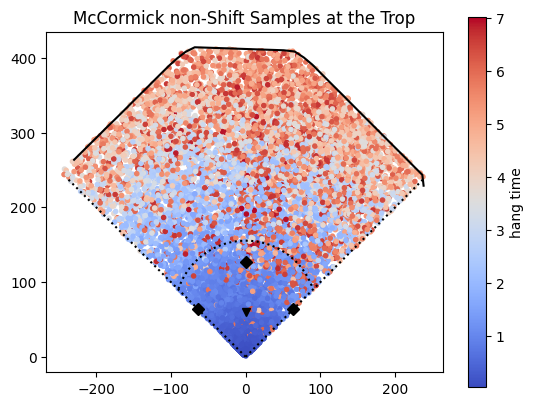

In [11]:
#plot
plt.scatter(samples.landing_x.values, samples.landing_y.values, c = samples.hangtime.values, marker = '.', cmap = 'coolwarm')
plt.colorbar(label = 'hang time')
bases_x = [0, -63.64, 63.64]
bases_y = [127.27, 63.64, 63.64]
mound = [0, 60.5]
circ = np.linspace(-90, 90, 100)
plt.plot([mound[0]], [mound[1]], 'kv')
plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
plt.plot(bases_x, bases_y, 'kD')
plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
plt.plot([0,240], [0,240], 'k:')
plt.plot([0,-240], [0,240], 'k:')
plt.gca().set_aspect('equal')
plt.title('McCormick non-Shift Samples at the Trop')
plt.show()

In [12]:
#shift samples
#draw horizontal angles first
choice = np.random.binomial(1, batter_info.batter_shift_w1.values, size = N)
hd_samp = choice * beta(a = batter_info.batter_shift_alpha1.values[0], b = batter_info.batter_shift_beta1.values[0]).rvs(N, random_state = 42) + (1-choice) * beta(a = batter_info.batter_shift_alpha2.values[0], b = batter_info.batter_shift_beta2.values[0]).rvs(N, random_state = 42)
#hd_samp is between 0 and 1, so shift and scale to get it back in terms of hit directions.
hd_samp = hd_samp * 110 -55

#now we need to define is_pull, is_oppo, and is_mid so that we can sample from the appropriate launch angle dist
is_pull = (hd_samp <= 0).astype(int)
is_oppo = (hd_samp > 0).astype(int)

#sample launch angles
la_samp = is_pull * norm(loc = batter_info.batter_mean_pull.values[0], scale = batter_info.batter_sigma_pull.values[0]).rvs(size = N, random_state = 42) + is_oppo * norm(loc = batter_info.batter_mean_oppo.values[0], scale = batter_info.batter_sigma_oppo.values[0]).rvs(size = N, random_state = 42)

#define the launch angle type
is_gb = (la_samp <= 10).astype(int)
is_ld = ((la_samp > 10).astype(int) + (la_samp <= 25).astype(int) == 2).astype(int)
is_pu = (la_samp > 50).astype(int)
is_fb = 1 - is_gb - is_ld - is_pu

#sample exit speeds
ev_samp = is_gb * gamma(a = batter_info.batter_a_gb.values[0], scale = batter_info.batter_s_gb.values[0]).rvs(size = N, random_state = 42) + is_fb * gamma(a = batter_info.batter_a_fb.values[0], scale = batter_info.batter_s_fb.values[0]).rvs(size = N, random_state = 42) + is_ld * gamma(a = batter_info.batter_a_ld.values[0], scale = batter_info.batter_s_ld.values[0]).rvs(size = N, random_state = 42) + is_pu * gamma(a = batter_info.batter_a_pu.values[0], scale = batter_info.batter_s_pu.values[0]).rvs(size = N, random_state = 42)

shiftsamples = pd.DataFrame({'batter_id': [batter for _ in range(N)], 'bat_handR': [bhand for _ in range(N)], 'is_pull': is_pull, 'is_oppo': is_oppo,
                    'is_gb': is_gb, 'is_ld': is_ld, 'is_fb': is_fb, 'is_pu': is_pu, 'hit_direction': hd_samp, 'launch_angle': la_samp, 'ev2': ev_samp})

#scale hit direction by -1 for lefty hitters
shiftsamples.loc[shiftsamples.bat_handR == 0, 'hit_direction'] *= -1

In [13]:
#define the launch speed
shiftsamples['launch_speed'] = -1*(shiftsamples.ev2.values - 123)
#remove bad launch speeds
shiftsamples.loc[shiftsamples.launch_speed < 10, 'launch_speed'] = 10

shiftsamples['hangtime'] = model_t.predict(shiftsamples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
shiftsamples['distance'] = model_dist.predict(shiftsamples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values)
#calculate landing x and y using distance and spray angle
shiftsamples['landing_x'] = shiftsamples.distance.values * np.sin(np.pi * shiftsamples.hit_direction.values / 180)
shiftsamples['landing_y'] = shiftsamples.distance.values * np.cos(np.pi * shiftsamples.hit_direction.values / 180)

#also predict xwoba given a hit for all batted balls. WE will use this to prioritize higher xwoba balls in our optimizer
shiftsamples['xwoba'] = xwoba_mod.predict_proba(shiftsamples[['launch_angle', 'launch_speed', 'hit_direction', 'bat_handR']].values) @ np.array([0.883, 1.244, 1.569, 2.004])

#remove balls that leave the trop
shiftsamples['wall_distance'] = [trop_dims.distance.values[np.argmin(np.abs(shiftsamples.hit_direction.values[i] - trop_dims.angle.values))] for i in range(shiftsamples.shape[0])]
shiftsamples= shiftsamples.loc[shiftsamples.distance < shiftsamples.wall_distance]

#remove balls that land foul
shiftsamples['landing_angle'] = np.arctan2(shiftsamples.landing_x.values, shiftsamples.landing_y.values) * 180/np.pi
shiftsamples = shiftsamples.loc[np.abs(shiftsamples.landing_angle) <= 45]

<ipython-input-13-d7411682bb3a>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  shiftsamples['landing_angle'] = np.arctan2(shiftsamples.landing_x.values, shiftsamples.landing_y.values) * 180/np.pi


In [14]:
shiftsamples = shiftsamples.sample(n=15000, replace = False)

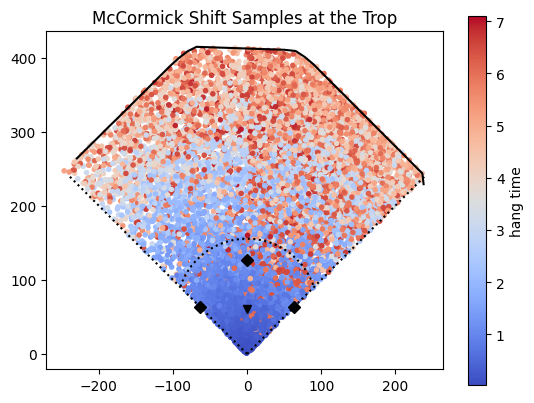

In [15]:
#plot
plt.scatter(shiftsamples.landing_x.values, shiftsamples.landing_y.values, c = shiftsamples.hangtime.values, marker = '.', cmap = 'coolwarm')
plt.colorbar(label = 'hang time')
bases_x = [0, -63.64, 63.64]
bases_y = [127.27, 63.64, 63.64]
mound = [0, 60.5]
circ = np.linspace(-90, 90, 100)
plt.plot([mound[0]], [mound[1]], 'kv')
plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
plt.plot(bases_x, bases_y, 'kD')
plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
plt.plot([0,240], [0,240], 'k:')
plt.plot([0,-240], [0,240], 'k:')
plt.gca().set_aspect('equal')
plt.title('McCormick Shift Samples at the Trop')
plt.show()

In [16]:
#we only have one batter, so set the batter index to 0
samples['batter_index'] = 0
shiftsamples['batter_index'] = 0

### Optimizing

In [17]:
#define the coefficients in the fly ball linear model and ground ball linear model
gb_int =-2.7808253
gb_angle_diff = -0.1463456
gb_bttf = 5.86696302
gb_bttf2 = -1.31835977

##### Fly ball regression model coefficients
fb_int = -2.16869748
fb_td_slope = 1.50402427

In [18]:
class DataSet(Dataset):
    def __init__(self, x,y):
        self.x = torch.tensor(x, dtype = torch.float32)
        self.y = torch.tensor(y, dtype = torch.float32)

        self.length = self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    def __len__(self):
        return self.length

#for the linear models, we need the landing coordinates, the hang time, the exit speed, the hit direction

features = ['landing_x', 'landing_y', 'launch_speed', 'hit_direction', 'hangtime', 'distance', 'is_gb', 'batter_index']

train_x = samples[features].values
train_y = samples.xwoba.values
trainset = DataSet(train_x, train_y)

trainloader = DataLoader(trainset, batch_size = 1500, shuffle = True)

shift_x = shiftsamples[features].values
shift_y = shiftsamples.xwoba.values
shiftset = DataSet(shift_x, shift_y)
shiftloader = DataLoader(shiftset, batch_size = 1500, shuffle = True)

In [19]:
#define a constraint function. Note that the embedding layer will not necessarily have the constraints applied, so we need to apply them before we make fielding recs
def constraint_func(bat_emb, constraint_type = 1):

    #first base constraint: must be within 40 feet from firstbase so he can cover the bag
    _1b = torch.tensor([[63.64, 63.64]]).to(device)
    p1b = bat_emb[:,0:2] - _1b
    _1b_dist = torch.norm(p1b, dim = 1)
    _1b_angle = torch.atan2(p1b[:,0], p1b[:,1])
    _1b_dist2 = _1b_dist.clone()
    #reset dists that are too far
    _1b_dist2[_1b_dist > 40] = 40.
    #reset coordinates by maintaining the same angle with first base but shrinking the distance
    p1bx = _1b_dist2 * torch.sin(_1b_angle) + 63.64
    p1by = _1b_dist2 * torch.cos(_1b_angle) + 63.64

    if constraint_type == 2:
      #shift ban constraint: infielders have to be in dirt and two on either side of second base.
      #That means we need the distance from each fielder to the center of the mound to be less than 95 ft based on this article: https://angelsnation.com/mlb-to-begin-enforcing-length-of-infield-dirt-at-stadiums/2022/10/23/
      #get the coordinates of the infielders relative to the mound
      mound = torch.tensor([[0, 60.5]]).to(device)
      mp3 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1)), dim = 1) - mound
      mp4 = bat_emb[:,2:4] - mound
      mp5 = bat_emb[:,4:6] - mound
      mp6 = bat_emb[:,6:8] - mound

      #get the player angles relative to the mound
      ma3 = torch.atan2(mp3[:,0], mp3[:,1])
      ma4 = torch.atan2(mp4[:,0], mp4[:,1])
      ma5 = torch.atan2(mp5[:,0], mp5[:,1])
      ma6 = torch.atan2(mp6[:,0], mp6[:,1])

      #get the depths relative to the mound. these will need to be less than or equal to 95 in order to stay in the dirt
      md3 = torch.norm(mp3, dim = 1)
      md4 = torch.norm(mp4, dim = 1)
      md5 = torch.norm(mp5, dim = 1)
      md6 = torch.norm(mp6, dim = 1)

      #reset depths greater than 95 to be 95. I think we need to clone these in order for backprop to work, but I'm not sure
      md32 = md3.clone()
      md42 = md4.clone()
      md52 = md5.clone()
      md62 = md6.clone()
      md32[md3 > 95] = 95.
      md42[md4 > 95] = 95.
      md52[md5 > 95] = 95.
      md62[md6 > 95] = 95.

      #reset illegal angles (by the shift ban) to be legal once again we need to clone
      ma32 = ma3.clone()
      ma42 = ma4.clone()
      ma52 = ma5.clone()
      ma62 = ma6.clone()
      ma32[ma3 < 0] = 0.
      ma42[ma4 < 0] = 0.
      ma52[ma5 > 0] = 0.
      ma62[ma6 > 0] = 0.

      #now we recalculate x and y coordinates with the new depth and and angle relative to the mound by converting from polar to cartesian. In baseball coords, x and y are sorta flipped because of the way angles are defined, so x = rsin(theta) and y = rcos(theta)
      x3 = md32 * torch.sin(ma32)
      y3 = md32 * torch.cos(ma32)
      x4 = md42 * torch.sin(ma42)
      y4 = md42 * torch.cos(ma42)
      x5 = md52 * torch.sin(ma52)
      y5 = md52 * torch.cos(ma52)
      x6 = md62 * torch.sin(ma62)
      y6 = md62 * torch.cos(ma62)

      #readjust coords to be relative to plate instead of mound like they were originally. Since the x coordinate is 0 for both the mound and plate, we only need to worry about the y's
      y3 = y3 + 60.5
      y4 = y4 + 60.5
      y5 = y5 + 60.5
      y6 = y6 + 60.5
      #define a new embedding with the constraints adjusted for
      bat_emb2 = torch.cat((x3.unsqueeze(1), y3.unsqueeze(1), x4.unsqueeze(1), y4.unsqueeze(1), x5.unsqueeze(1), y5.unsqueeze(1), x6.unsqueeze(1), y6.unsqueeze(1), bat_emb[:,8:].clone()), dim = 1)

    elif constraint_type == 3:
      #infielders must be within 110 feet of the mound
      mound = torch.tensor([[0, 60.5]]).to(device)
      mp3 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1)), dim = 1) - mound
      mp4 = bat_emb[:,2:4] - mound
      mp5 = bat_emb[:,4:6] - mound
      mp6 = bat_emb[:,6:8] - mound

      #get the player angles relative to the mound
      ma3 = torch.atan2(mp3[:,0], mp3[:,1])
      ma4 = torch.atan2(mp4[:,0], mp4[:,1])
      ma5 = torch.atan2(mp5[:,0], mp5[:,1])
      ma6 = torch.atan2(mp6[:,0], mp6[:,1])

      #get the depths relative to the mound
      md3 = torch.norm(mp3, dim = 1)
      md4 = torch.norm(mp4, dim = 1)
      md5 = torch.norm(mp5, dim = 1)
      md6 = torch.norm(mp6, dim = 1)

      #reset depths greater than 110 to 110. I think we need to clone these in order for backprop to work, but I'm not sure
      md32 = md3.clone()
      md42 = md4.clone()
      md52 = md5.clone()
      md62 = md6.clone()
      md32[md3 > 100] = 100.
      md42[md4 > 100] = 100.
      md52[md5 > 100] = 100.
      md62[md6 > 100] = 100.


      #now we recalculate x and y coordinates with the new depth and and angle relative to the mound by converting from polar to cartesian. In baseball coords, x and y are sorta flipped because of the way angles are defined, so x = rsin(theta) and y = rcos(theta)
      x3 = md32 * torch.sin(ma3)
      y3 = md32 * torch.cos(ma3)
      x4 = md42 * torch.sin(ma4)
      y4 = md42 * torch.cos(ma4)
      x5 = md52 * torch.sin(ma5)
      y5 = md52 * torch.cos(ma5)
      x6 = md62 * torch.sin(ma6)
      y6 = md62 * torch.cos(ma6)

      #readjust coords to be relative to plate instead of mound like they were originally. Since the x coordinate is 0 for both the mound and plate, we only need to worry about the y's
      y3 = y3 + 60.5
      y4 = y4 + 60.5
      y5 = y5 + 60.5
      y6 = y6 + 60.5
      #define a new embedding with the constraints adjusted for
      bat_emb2 = torch.cat((x3.unsqueeze(1), y3.unsqueeze(1), x4.unsqueeze(1), y4.unsqueeze(1), x5.unsqueeze(1), y5.unsqueeze(1), x6.unsqueeze(1), y6.unsqueeze(1), bat_emb[:,8:].clone()), dim = 1)

    else:
      #no shift ban
      bat_emb2 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1), bat_emb[:,2:].clone()), dim = 1)

    return bat_emb2

class Optimizer(nn.Module):
    def __init__(self, constraint_type = 1):
        super().__init__()

        self.embed = nn.Embedding(samples.batter_index.max() + 1, embedding_dim = 14).to(device)

        #initialize the embedding
        default = np.array([71.6, 90, 25.5, 137.7, -67.6, 93, -37.4, 134.9, -124.3, 256.5, 0, 325, 124.3, 256.5])
        self.embed.weight.data = torch.tensor(default, dtype = torch.float32).repeat((samples.batter_index.max()+1,1)).to(device)

        #the constraint types are 1 and 2. 1 is no constraints except firstbaseman has to be able to cover. 2 is shift ban constraints from 2023
        self.constraint_type = constraint_type

    def forward(self, x):
        batter_idx = x[:,-1].int()
        bat_emb = self.embed(batter_idx)

        #first base constraint: must be within 40 feet from firstbase so he can cover the bag
        _1b = torch.tensor([[63.64, 63.64]]).to(device)
        p1b = bat_emb[:,0:2] - _1b
        _1b_dist = torch.norm(p1b, dim = 1)
        _1b_angle = torch.atan2(p1b[:,0], p1b[:,1])
        _1b_dist2 = _1b_dist.clone()
        #reset dists that are too far
        _1b_dist2[_1b_dist > 40] = 40.
        #reset coordinates by maintaining the same angle with first base but shrinking the distance
        p1bx = _1b_dist2 * torch.sin(_1b_angle) + 63.64
        p1by = _1b_dist2 * torch.cos(_1b_angle) + 63.64

        if self.constraint_type == 2:
          #shift ban constraint: infielders have to be in dirt and two on either side of second base.
          #That means we need the distance from each fielder to the center of the mound to be less than 95 ft based on this article: https://angelsnation.com/mlb-to-begin-enforcing-length-of-infield-dirt-at-stadiums/2022/10/23/
          #get the coordinates of the infielders relative to the mound
          mound = torch.tensor([[0, 60.5]]).to(device)
          mp3 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1)), dim = 1) - mound
          mp4 = bat_emb[:,2:4] - mound
          mp5 = bat_emb[:,4:6] - mound
          mp6 = bat_emb[:,6:8] - mound

          #get the player angles relative to the mound
          ma3 = torch.atan2(mp3[:,0], mp3[:,1])
          ma4 = torch.atan2(mp4[:,0], mp4[:,1])
          ma5 = torch.atan2(mp5[:,0], mp5[:,1])
          ma6 = torch.atan2(mp6[:,0], mp6[:,1])

          #get the depths relative to the mound. these will need to be less than or equal to 95 in order to stay in the dirt
          md3 = torch.norm(mp3, dim = 1)
          md4 = torch.norm(mp4, dim = 1)
          md5 = torch.norm(mp5, dim = 1)
          md6 = torch.norm(mp6, dim = 1)

          #reset depths greater than 95 to be 95. I think we need to clone these in order for backprop to work, but I'm not sure
          md32 = md3.clone()
          md42 = md4.clone()
          md52 = md5.clone()
          md62 = md6.clone()
          md32[md3 > 95] = 95.
          md42[md4 > 95] = 95.
          md52[md5 > 95] = 95.
          md62[md6 > 95] = 95.

          #reset illegal angles (by the shift ban) to be legal once again we need to clone
          ma32 = ma3.clone()
          ma42 = ma4.clone()
          ma52 = ma5.clone()
          ma62 = ma6.clone()
          ma32[ma3 < 0] = 0.
          ma42[ma4 < 0] = 0.
          ma52[ma5 > 0] = 0.
          ma62[ma6 > 0] = 0.

          #now we recalculate x and y coordinates with the new depth and and angle relative to the mound by converting from polar to cartesian. In baseball coords, x and y are sorta flipped because of the way angles are defined, so x = rsin(theta) and y = rcos(theta)
          x3 = md32 * torch.sin(ma32)
          y3 = md32 * torch.cos(ma32)
          x4 = md42 * torch.sin(ma42)
          y4 = md42 * torch.cos(ma42)
          x5 = md52 * torch.sin(ma52)
          y5 = md52 * torch.cos(ma52)
          x6 = md62 * torch.sin(ma62)
          y6 = md62 * torch.cos(ma62)

          #readjust coords to be relative to plate instead of mound like they were originally. Since the x coordinate is 0 for both the mound and plate, we only need to worry about the y's
          y3 = y3 + 60.5
          y4 = y4 + 60.5
          y5 = y5 + 60.5
          y6 = y6 + 60.5
          #define a new embedding with the constraints adjusted for
          bat_emb2 = torch.cat((x3.unsqueeze(1), y3.unsqueeze(1), x4.unsqueeze(1), y4.unsqueeze(1), x5.unsqueeze(1), y5.unsqueeze(1), x6.unsqueeze(1), y6.unsqueeze(1), bat_emb[:,8:].clone()), dim = 1)

        elif self.constraint_type == 3:
          #infielders must be within 110 feet of the mound
          mound = torch.tensor([[0, 60.5]]).to(device)
          mp3 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1)), dim = 1) - mound
          mp4 = bat_emb[:,2:4] - mound
          mp5 = bat_emb[:,4:6] - mound
          mp6 = bat_emb[:,6:8] - mound

          #get the player angles relative to the mound
          ma3 = torch.atan2(mp3[:,0], mp3[:,1])
          ma4 = torch.atan2(mp4[:,0], mp4[:,1])
          ma5 = torch.atan2(mp5[:,0], mp5[:,1])
          ma6 = torch.atan2(mp6[:,0], mp6[:,1])

          #get the depths relative to the mound
          md3 = torch.norm(mp3, dim = 1)
          md4 = torch.norm(mp4, dim = 1)
          md5 = torch.norm(mp5, dim = 1)
          md6 = torch.norm(mp6, dim = 1)

          #reset depths greater than 110 to 110. I think we need to clone these in order for backprop to work, but I'm not sure
          md32 = md3.clone()
          md42 = md4.clone()
          md52 = md5.clone()
          md62 = md6.clone()
          md32[md3 > 100] = 100.
          md42[md4 > 100] = 100.
          md52[md5 > 100] = 100.
          md62[md6 > 100] = 100.


          #now we recalculate x and y coordinates with the new depth and and angle relative to the mound by converting from polar to cartesian. In baseball coords, x and y are sorta flipped because of the way angles are defined, so x = rsin(theta) and y = rcos(theta)
          x3 = md32 * torch.sin(ma3)
          y3 = md32 * torch.cos(ma3)
          x4 = md42 * torch.sin(ma4)
          y4 = md42 * torch.cos(ma4)
          x5 = md52 * torch.sin(ma5)
          y5 = md52 * torch.cos(ma5)
          x6 = md62 * torch.sin(ma6)
          y6 = md62 * torch.cos(ma6)

          #readjust coords to be relative to plate instead of mound like they were originally. Since the x coordinate is 0 for both the mound and plate, we only need to worry about the y's
          y3 = y3 + 60.5
          y4 = y4 + 60.5
          y5 = y5 + 60.5
          y6 = y6 + 60.5
          #define a new embedding with the constraints adjusted for
          bat_emb2 = torch.cat((x3.unsqueeze(1), y3.unsqueeze(1), x4.unsqueeze(1), y4.unsqueeze(1), x5.unsqueeze(1), y5.unsqueeze(1), x6.unsqueeze(1), y6.unsqueeze(1), bat_emb[:,8:].clone()), dim = 1)

        else:
          #no shift ban
          bat_emb2 = torch.cat((p1bx.unsqueeze(1), p1by.unsqueeze(1), bat_emb[:,2:].clone()), dim = 1)

        #################################################################################################################################################################################################
        #get fielder depths
        first_depth = torch.norm(bat_emb2[:,:2], dim = 1).unsqueeze(1)
        second_depth = torch.norm(bat_emb2[:,2:4], dim = 1).unsqueeze(1)
        third_depth = torch.norm(bat_emb2[:,4:6], dim = 1).unsqueeze(1)
        ss_depth = torch.norm(bat_emb2[:,6:8], dim = 1).unsqueeze(1)
        lf_depth = torch.norm(bat_emb2[:,8:10], dim = 1).unsqueeze(1)
        cf_depth = torch.norm(bat_emb2[:,10:12], dim = 1).unsqueeze(1)
        rf_depth = torch.norm(bat_emb2[:,12:14], dim = 1).unsqueeze(1)
        depths = torch.cat((first_depth, second_depth, third_depth, ss_depth, lf_depth, cf_depth, rf_depth), dim = -1)

        ##### Flyballs
        # we need the closest fielder to the landing spot
        landing_spot = x[:,:2]
        first_dist = torch.norm(bat_emb2[:,:2] - landing_spot, dim = 1).unsqueeze(1)
        second_dist = torch.norm(bat_emb2[:,2:4] - landing_spot, dim = 1).unsqueeze(1)
        third_dist = torch.norm(bat_emb2[:,4:6] - landing_spot, dim = 1).unsqueeze(1)
        ss_dist = torch.norm(bat_emb2[:,6:8] - landing_spot, dim = 1).unsqueeze(1)
        lf_dist = torch.norm(bat_emb2[:,8:10] - landing_spot, dim = 1).unsqueeze(1)
        cf_dist = torch.norm(bat_emb2[:,10:12] - landing_spot, dim = 1).unsqueeze(1)
        rf_dist = torch.norm(bat_emb2[:,12:14] - landing_spot, dim = 1).unsqueeze(1)
        dists = torch.cat((first_dist, second_dist, third_dist, ss_dist, lf_dist, cf_dist, rf_dist), dim = -1)
        mindist, mindist_index = torch.min(dists, dim = 1)
        #now we need the timediff, which is the time it takes an average runner (27 ft/s) to cover mindist subtracted from the hang time
        timediff = x[:,4] - (mindist / 27)

        #now we can calculate fly ball out probability
        fb_prob_outs = torch.special.expit(fb_int + timediff * fb_td_slope)

        #### Groundballs
        #calculate fielder angles
        a3 = torch.arctan2(bat_emb2[:,0], bat_emb2[:,1]) * 180/np.pi
        a4 = torch.arctan2(bat_emb2[:,2], bat_emb2[:,3]) * 180/np.pi
        a5 = torch.arctan2(bat_emb2[:,4], bat_emb2[:,5]) * 180/np.pi
        a6 = torch.arctan2(bat_emb2[:,6], bat_emb2[:,7]) * 180/np.pi
        a7 = torch.arctan2(bat_emb2[:,8], bat_emb2[:,9]) * 180/np.pi
        a8 = torch.arctan2(bat_emb2[:,10], bat_emb2[:,11]) * 180/np.pi
        a9 = torch.arctan2(bat_emb2[:,12], bat_emb2[:,13]) * 180/np.pi

        #get the angle diffs
        hd = x[:,3]
        ad3 = (a3 -hd).unsqueeze(1)
        ad4 = (a4-hd).unsqueeze(1)
        ad5 = (a5-hd).unsqueeze(1)
        ad6 = (a6-hd).unsqueeze(1)
        ad7 = (a7-hd).unsqueeze(1)
        ad8 = (a8-hd).unsqueeze(1)
        ad9 = (a9-hd).unsqueeze(1)
        angle_diffs = torch.cat((ad3, ad4, ad5, ad6, ad7, ad8, ad9), dim = -1)

        #get the closest infielder by absolute angle dist, so we need to make sure non infielders aren't counted by setting their values really large
        inf_ad3 = ad3.clone()
        inf_ad4 = ad4.clone()
        inf_ad5 = ad5.clone()
        inf_ad6 = ad6.clone()
        inf_ad7 = ad7.clone()
        inf_ad8 = ad8.clone()
        inf_ad9 = ad9.clone()
        inf_ad3[first_depth > 200] = 1000.
        inf_ad4[second_depth > 200] = 1000.
        inf_ad5[third_depth > 200] = 1000.
        inf_ad6[ss_depth > 200] = 1000.
        inf_ad7[lf_depth > 200] = 1000.
        inf_ad8[cf_depth > 200] = 1000.
        inf_ad9[rf_depth > 200] = 1000.
        inf_vals = torch.abs(torch.cat((inf_ad3, inf_ad4, inf_ad5, inf_ad6, inf_ad7, inf_ad8, inf_ad9), dim = -1))
        closest_ifer, closest_ifer_index = torch.min(inf_vals, dim = 1)
        #we need their depth and absolute angle diff
        closest_ifer_depth = depths[torch.arange(depths.size(0)), closest_ifer_index].unsqueeze(1)
        closest_ifer_angle = torch.abs(angle_diffs[torch.arange(depths.size(0)), closest_ifer_index].unsqueeze(1))
        #calcluate the ball time to fielder, depth divided by exit speed in feet per second.
        bttf = closest_ifer_depth.squeeze(1) / (x[:,2] * 1.4667)

        #now we can calculate ground ball out probability using the regression model
        gb_prob_outs = torch.special.expit(gb_int + gb_angle_diff * closest_ifer_angle.squeeze(1) + gb_bttf * bttf + gb_bttf2 * bttf**2)

        #the final out probability depends on if it is a ground ball or fly ball
        is_gb = x[:,6]
        return is_gb * gb_prob_outs + (1-is_gb) * fb_prob_outs


In [20]:
#define my custom loss function, maximize outs, so minimize negative outs
def maximize_outs(output, target = None):
    #we just return the negative mean of outs. We want to minimze that
    return -1*torch.mean(output)

#minimize woba
def minimize_woba(output, target):
    #output would obviously be the output of the net, which is an out probability. Target is the woba of a hit, so we take 1-out prob and multiply that by target, and that gives xwoba of a non out, and we want to minimize this
    return torch.mean((1-output) * target)

### non shift dist optimization

In [21]:
#training parameters
learning_rate = 1
epochs = 2000
loss_fn = maximize_outs

opt1 = Optimizer(3).to(device)
optimizer = torch.optim.SGD(opt1.parameters(), lr = learning_rate, momentum = 0.9)
train_losses = []

epoch : 1/2000, loss = -0.682549
epoch : 2/2000, loss = -0.682646
epoch : 3/2000, loss = -0.682787
epoch : 4/2000, loss = -0.682965
epoch : 5/2000, loss = -0.683113
epoch : 6/2000, loss = -0.683245
epoch : 7/2000, loss = -0.683429
epoch : 8/2000, loss = -0.683585
epoch : 9/2000, loss = -0.683732
epoch : 10/2000, loss = -0.683906
epoch : 11/2000, loss = -0.684057
epoch : 12/2000, loss = -0.684206
epoch : 13/2000, loss = -0.684388
epoch : 14/2000, loss = -0.684555
epoch : 15/2000, loss = -0.684709
epoch : 16/2000, loss = -0.684875
epoch : 17/2000, loss = -0.685043
epoch : 18/2000, loss = -0.685190
epoch : 19/2000, loss = -0.685336
epoch : 20/2000, loss = -0.685510
epoch : 21/2000, loss = -0.685648
epoch : 22/2000, loss = -0.685810
epoch : 23/2000, loss = -0.685953
epoch : 24/2000, loss = -0.686115
epoch : 25/2000, loss = -0.686232
epoch : 26/2000, loss = -0.686375
epoch : 27/2000, loss = -0.686545
epoch : 28/2000, loss = -0.686708
epoch : 29/2000, loss = -0.686851
epoch : 30/2000, loss =

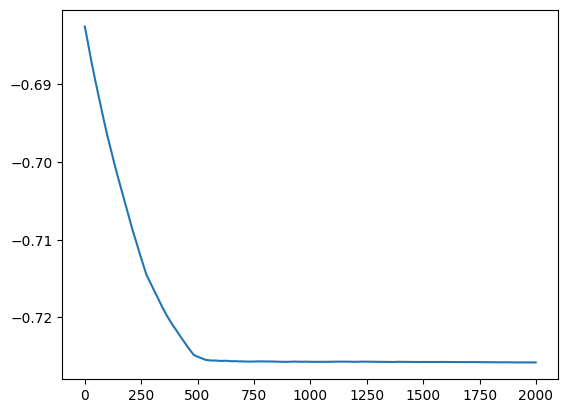

In [22]:
#training: loops
for i in range(epochs):
    #loop through batches of training data
    loss_val = 0
    for batch, (x, y) in enumerate(trainloader):
        x = x.to(device)
        y = y.to(device)
        #zero out gradients
        optimizer.zero_grad()
        #run the model
        outputs = opt1(x)
        #calculate loss
        loss = loss_fn(outputs, y)
        loss_val += loss.item()
        #backprop
        loss.backward()
        optimizer.step()


    train_losses.append(loss_val / len(trainloader))

    print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

plt.plot(train_losses)
plt.show()

#save the results
bat_embeddings = opt1.embed.weight.data
constrained = constraint_func(bat_embeddings, 3)
batter_weights1 = pd.DataFrame({'batter_id': [batter], 'bat_handR': [bhand]}, index = [0])
batter_weights1[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9']] = constrained.detach().cpu().numpy()[0,:]

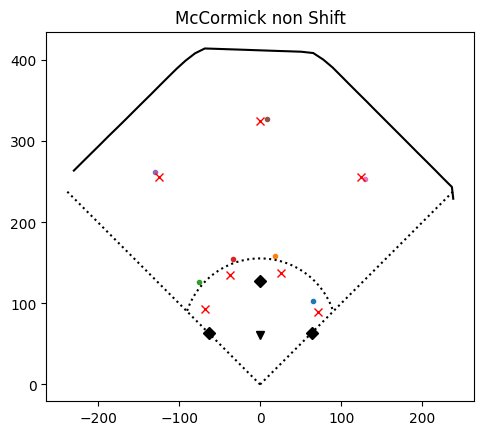

In [23]:
standard_pos = np.array([71.6, 90, 25.5, 137.7, -67.6, 93, -37.4, 134.9, -124.3, 256.5, 0, 325, 124.3, 256.5])
for i in range(7):
    plt.plot(batter_weights1['x' + str(i + 3)], batter_weights1['y' + str(i+3)], '.')
    plt.plot([standard_pos[2*i]], [standard_pos[2*i+1]], 'rx')
plt.plot([mound[0]], [mound[1]], 'kv')
plt.plot(bases_x, bases_y, 'kD')
plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
plt.plot([0,240], [0,240], 'k:')
plt.plot([0,-240], [0,240], 'k:')
plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
plt.gca().set_aspect('equal')
plt.title('McCormick non Shift')
plt.show()

### Optimize for shift dist

In [24]:
#training parameters
learning_rate = 1
epochs = 2000
loss_fn = maximize_outs

opt2 = Optimizer(3).to(device)
optimizer = torch.optim.SGD(opt2.parameters(), lr = learning_rate, momentum = 0.9)
train_losses = []

epoch : 1/2000, loss = -0.689475
epoch : 2/2000, loss = -0.689578
epoch : 3/2000, loss = -0.689722
epoch : 4/2000, loss = -0.689850
epoch : 5/2000, loss = -0.689988
epoch : 6/2000, loss = -0.690131
epoch : 7/2000, loss = -0.690295
epoch : 8/2000, loss = -0.690447
epoch : 9/2000, loss = -0.690599
epoch : 10/2000, loss = -0.690744
epoch : 11/2000, loss = -0.690905
epoch : 12/2000, loss = -0.691046
epoch : 13/2000, loss = -0.691173
epoch : 14/2000, loss = -0.691276
epoch : 15/2000, loss = -0.691380
epoch : 16/2000, loss = -0.691520
epoch : 17/2000, loss = -0.691659
epoch : 18/2000, loss = -0.691796
epoch : 19/2000, loss = -0.691934
epoch : 20/2000, loss = -0.692085
epoch : 21/2000, loss = -0.692205
epoch : 22/2000, loss = -0.692312
epoch : 23/2000, loss = -0.692468
epoch : 24/2000, loss = -0.692606
epoch : 25/2000, loss = -0.692722
epoch : 26/2000, loss = -0.692834
epoch : 27/2000, loss = -0.692980
epoch : 28/2000, loss = -0.693124
epoch : 29/2000, loss = -0.693276
epoch : 30/2000, loss =

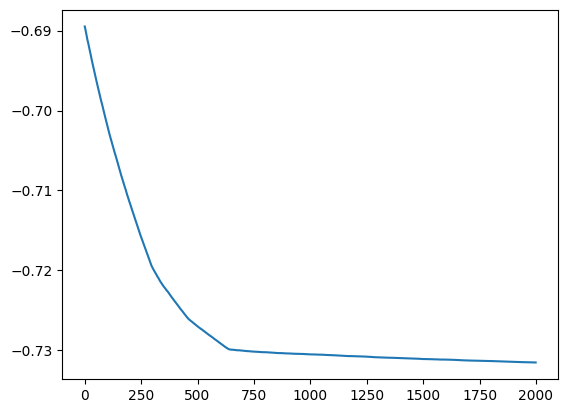

In [25]:
#training: loops
for i in range(epochs):
    #loop through batches of training data
    loss_val = 0
    for batch, (x, y) in enumerate(shiftloader):
        x = x.to(device)
        y = y.to(device)
        #zero out gradients
        optimizer.zero_grad()
        #run the model
        outputs = opt2(x)
        #calculate loss
        loss = loss_fn(outputs, y)
        loss_val += loss.item()
        #backprop
        loss.backward()
        optimizer.step()


    train_losses.append(loss_val / len(shiftloader))

    print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

plt.plot(train_losses)
plt.show()

#save the results
bat_embeddings = opt2.embed.weight.data
constrained = constraint_func(bat_embeddings, 3)
batter_weights2 = pd.DataFrame({'batter_id': [batter], 'bat_handR': [bhand]}, index = [0])
batter_weights2[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9']] = constrained.detach().cpu().numpy()[0,:]

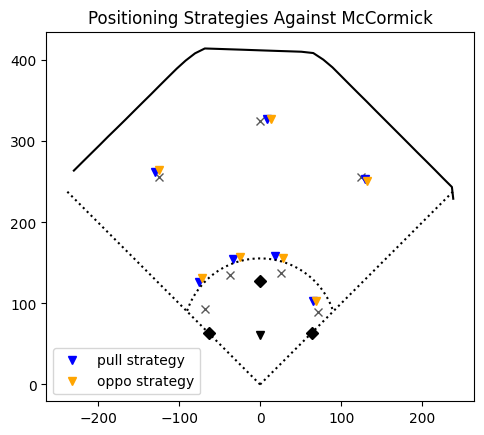

In [32]:
for i in range(7):
    plt.plot(standard_pos[2*i], standard_pos[2*i+1], 'kx', alpha = 0.65)
    if i == 6:
      plt.plot(batter_weights1['x' + str(i + 3)], batter_weights1['y' + str(i + 3)], 'bv', label = 'pull strategy')
      plt.plot(batter_weights2['x' + str(i + 3)], batter_weights2['y' + str(i+3)], 'v', color = 'orange', label = 'oppo strategy')
    else:
      plt.plot(batter_weights1['x' + str(i + 3)], batter_weights1['y' + str(i + 3)], 'bv')
      plt.plot(batter_weights2['x' + str(i + 3)], batter_weights2['y' + str(i+3)], 'v', color = 'orange')
plt.plot([mound[0]], [mound[1]], 'kv')
plt.plot(bases_x, bases_y, 'kD')
plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
plt.plot([0,240], [0,240], 'k:')
plt.plot([0,-240], [0,240], 'k:')
plt.gca().set_aspect('equal')
plt.title('Positioning Strategies Against McCormick')
plt.plot(trop_dims.x.values, trop_dims.y.values, 'k-')
plt.legend()
plt.show()

In [27]:
#calculate the final loss
x = shiftset[:][0].to(device)
y = shiftset[:][1].to(device)
outputs = opt2(x)
loss = loss_fn(outputs, y)
loss_val = loss.item()
print('Expected batting average if McCormick uses shift-beating strategy against the anti-shift-beater defense: ' + str(1+loss_val))
outputs = opt1(x)
loss = loss_fn(outputs, y)
loss_val = loss.item()
print('Expected batting average if McCormick uses shift-beating strategy against shift defense: ' + str(1+loss_val))

x = trainset[:][0].to(device)
y = trainset[:][1].to(device)
outputs = opt2(x)
loss = loss_fn(outputs, y)
loss_val = loss.item()
print('Expected batting average if McCormick uses non-shift-beating strategy against anti-shift-beater defense: ' + str(1+loss_val))
outputs = opt1(x)
loss = loss_fn(outputs, y)
loss_val = loss.item()
print('Expected batting average if McCormick uses non-shift-beating strategy against the shift defense: ' + str(1+loss_val))

Expected batting average if McCormick uses shift-beating strategy against the anti-shift-beater defense: 0.2684727907180786
Expected batting average if McCormick uses shift-beating strategy against shift defense: 0.27051007747650146
Expected batting average if McCormick uses non-shift-beating strategy against anti-shift-beater defense: 0.27500319480895996
Expected batting average if McCormick uses non-shift-beating strategy against the shift defense: 0.27420109510421753


We see here that McCormick has a dominant strategy. Against either defensive strategy, McCormick has a higher expected batting average if he uses his non-shift-beating strategy. When McCormick uses that strategy, the defense is better off in the regular shift defense. Thus, when we solve for an equilibrium in the next section, I expect the strategy will end up being McCormick using non-shift beating dist and the defense using their regular shift defense.

### Stackelberg Equilibrium

In [28]:
#training parameters
learning_rate = 1
epochs = 2000
loss_fn = maximize_outs

opt3 = Optimizer(3).to(device)
optimizer = torch.optim.SGD(opt3.parameters(), lr = learning_rate, momentum = 0.9)
train_losses = []

epoch : 1/2000, loss = -0.682540
epoch : 2/2000, loss = -0.682647
epoch : 3/2000, loss = -0.682808
epoch : 4/2000, loss = -0.682954
epoch : 5/2000, loss = -0.683113
epoch : 6/2000, loss = -0.683255
epoch : 7/2000, loss = -0.683418
epoch : 8/2000, loss = -0.683584
epoch : 9/2000, loss = -0.683733
epoch : 10/2000, loss = -0.683914
epoch : 11/2000, loss = -0.684065
epoch : 12/2000, loss = -0.684217
epoch : 13/2000, loss = -0.684386
epoch : 14/2000, loss = -0.684555
epoch : 15/2000, loss = -0.684704
epoch : 16/2000, loss = -0.684876
epoch : 17/2000, loss = -0.685042
epoch : 18/2000, loss = -0.685179
epoch : 19/2000, loss = -0.685344
epoch : 20/2000, loss = -0.685511
epoch : 21/2000, loss = -0.685656
epoch : 22/2000, loss = -0.685810
epoch : 23/2000, loss = -0.685953
epoch : 24/2000, loss = -0.686115
epoch : 25/2000, loss = -0.686258
epoch : 26/2000, loss = -0.686374
epoch : 27/2000, loss = -0.686544
epoch : 28/2000, loss = -0.686697
epoch : 29/2000, loss = -0.686850
epoch : 30/2000, loss =

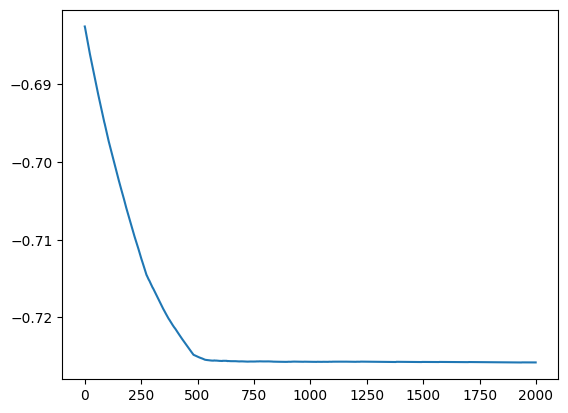

In [29]:
#training: loops
for i in range(epochs):
    #figure out whether McCormick will use his standard strategy or his shift beating strategy against the current defense
    x = trainset[:][0].to(device)
    y = trainset[:][1].to(device)
    outputs = opt3(x)
    loss = loss_fn(outputs, y)
    standard_loss = loss.item()
    x = shiftset[:][0].to(device)
    y = shiftset[:][1].to(device)
    outputs = opt3(x)
    loss = loss_fn(outputs, y)
    shift_loss = loss.item()

    if shift_loss > standard_loss:
        #McCormick uses the shift beater strategy
        #loop through batches of training data
        loss_val = 0
        for batch, (x, y) in enumerate(shiftloader):
            x = x.to(device)
            y = y.to(device)
            #zero out gradients
            optimizer.zero_grad()
            #run the model
            outputs = opt3(x)
            #calculate loss
            loss = loss_fn(outputs, y)
            loss_val += loss.item()
            #backprop
            loss.backward()
            optimizer.step()


        train_losses.append(loss_val / len(shiftloader))

        print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

    else:
        #McCormick uses the standard strategy
        #loop through batches of training data
        loss_val = 0
        for batch, (x, y) in enumerate(trainloader):
            x = x.to(device)
            y = y.to(device)
            #zero out gradients
            optimizer.zero_grad()
            #run the model
            outputs = opt3(x)
            #calculate loss
            loss = loss_fn(outputs, y)
            loss_val += loss.item()
            #backprop
            loss.backward()
            optimizer.step()


        train_losses.append(loss_val / len(trainloader))

        print('epoch : {}/{}, loss = {:.6f}'.format(i + 1, epochs, train_losses[-1]))

plt.plot(train_losses)
plt.show()

#save the results. Note both opt3 and bopt3 should now have the same embeddings, so you can use either one here
bat_embeddings = opt3.embed.weight.data
constrained = constraint_func(bat_embeddings, 3)
batter_weights3 = pd.DataFrame({'batter_id': [batter], 'bat_handR': [bhand]}, index = [0])
batter_weights3[['x3', 'y3', 'x4', 'y4', 'x5', 'y5', 'x6', 'y6', 'x7', 'y7', 'x8', 'y8', 'x9', 'y9']] = constrained.detach().cpu().numpy()[0,:]

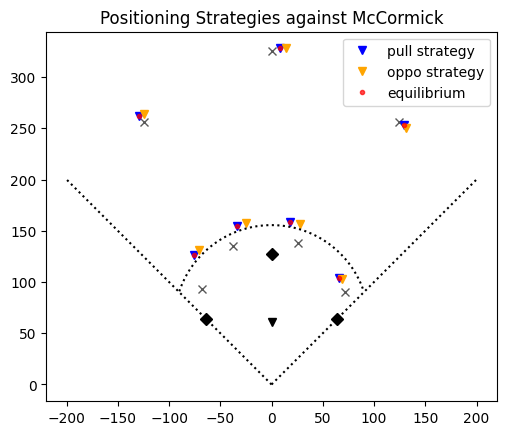

In [35]:
for i in range(7):
    plt.plot(standard_pos[2*i], standard_pos[2*i+1], 'kx', alpha = 0.65)
    if i == 6:
      plt.plot(batter_weights1['x' + str(i + 3)], batter_weights1['y' + str(i + 3)], 'bv', label = 'pull strategy')
      plt.plot(batter_weights2['x' + str(i + 3)], batter_weights2['y' + str(i+3)], 'v', color = 'orange', label = 'oppo strategy')
      plt.plot(batter_weights3['x' + str(i + 3)], batter_weights3['y' + str(i+3)], 'r.', label = 'equilibrium', alpha = 0.7)
    else:
      plt.plot(batter_weights1['x' + str(i + 3)], batter_weights1['y' + str(i + 3)], 'bv')
      plt.plot(batter_weights2['x' + str(i + 3)], batter_weights2['y' + str(i+3)], 'v', color = 'orange')
      plt.plot(batter_weights3['x' + str(i + 3)], batter_weights3['y' + str(i+3)], 'r.', alpha = 0.7)
plt.plot([mound[0]], [mound[1]], 'kv')
plt.plot(bases_x, bases_y, 'kD')
plt.plot(circ, np.sqrt(95**2 - (circ)**2) + 60.5, 'k:')
plt.plot([0,200], [0,200], 'k:')
plt.plot([0,-200], [0,200], 'k:')
plt.gca().set_aspect('equal')
plt.legend()
plt.title('Positioning Strategies against McCormick')
plt.show()

We see in this plot that the equilibrium defense lines up with the strategy we got when we assumed that McCormick would use his non-shift-beating strategy. This is a dominant strategy, so it turns out that it is fair to assume that he will always use that strategy regardless of where the defense is standing (at least in whatever small subset of the positioning strategies we tested. It is dominant in that subset).

In [36]:
#calculate the final loss
x = shiftset[:][0].to(device)
y = shiftset[:][1].to(device)
outputs = opt3(x)
loss = loss_fn(outputs, y)
loss_val = loss.item()
print('Expected batting average if McCormick uses shift-beating strategy against the equilibrium defense: ' + str(1+loss_val))

x = trainset[:][0].to(device)
y = trainset[:][1].to(device)
outputs = opt3(x)
loss = loss_fn(outputs, y)
loss_val = loss.item()
print('Expected batting average if McCormick uses non-shift-beating strategy against the equilibrium defense: ' + str(1+loss_val))

Expected batting average if McCormick uses shift-beating strategy against the equilibrium defense: 0.27051013708114624
Expected batting average if McCormick uses non-shift-beating strategy against the equilibrium defense: 0.27420103549957275


Just as I suspected, the equilibrium strategy has the defense using the same strategy that they used when we assumed McCormick would use his non-shift-beating strategy, which we found to be dominant in the previous section. And therefore of course, McCormick is best off responding with that strategy, giving an expected batting average of 0.274.